Analyze SBI-SGM, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)

## Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

def divideFc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divideFc(fc1)
    blocks2 = divideFc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [5]:
def _simulate_data(raw_params, brain, prior_bds, freqrange, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange, diag_ws)
    return np.abs(modelFC[:68, :68])

In [6]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [7]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [8]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [9]:
from scipy.io import loadmat
# The array is ordered as in ‘alpha’, ‘beta_l’, ‘delta’, ‘theta’
#diag_ws = np.abs(diag_ws).mean(axis=(1, 2))
#diag_ws = np.concatenate([diag_ws, np.ones(14)*diag_ws[-1]])
#diag_ws[0] = 1 # make it to 1, remove it leads to very poor results (on May 4, 2023)                                                                                       
#diag_ws[0] = 0 # remove it
#diag_ws = (diag_ws - np.min(diag_ws))/(np.max(diag_ws)-np.min(diag_ws))
#diag_ws = np.log(diag_ws/np.min(diag_ws))
diag_ws = np.ones(82)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
#bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0));
bnds = ((0.005,0.030), (v_lower,v_upper), (0.1,1.0));
#taue,taui,tauG,speed,alpha,gii,gei

In [11]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]


In [44]:
paras = edict()

paras.band= "alpha" #stick to coh
paras.freqrange =  np.linspace(_paras[paras.band][0], _paras[paras.band][1], 5)
paras.diag_ws = diag_ws
print(paras.freqrange)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.add_v = 0.01
paras.nepoch = 100
paras.k = 1 # without ann, k=0.1, with ann, k = 1

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 3
paras.SBI_paras.noise_sd = 1.60
#paras.SBI_paras.save_dir =  f"rawfc2ep{paras.nepoch}_posteriorMRmul_{paras.band}_" + \
paras.SBI_paras.save_dir =  f"rawfc2annep{paras.nepoch}_posteriorMRmul_{paras.band}_" + \
                            f"num{paras.SBI_paras.num_prior_sps}_" + \
                            f"density{paras.SBI_paras.density_model}_" + \
                            f"MR{paras.SBI_paras.num_round}_" + \
                            f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
                            f"addv{paras.add_v*100:.0f}"
print(paras.SBI_paras.save_dir)
assert (RES_ROOT/paras.SBI_paras.save_dir).exists()
paras.diag_ws

[ 8.  9. 10. 11. 12.]
rawfc2annep100_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd160_addv1


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [45]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=paras.k)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=paras.k))

functools.partial(<function theta_raw_2out at 0x7fcac14ebdc0>, map_fn=functools.partial(<function logistic_np at 0x7fcac14ebd30>, k=1))

### Load the data

In [46]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [47]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [48]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{paras.band}*nepoch-{paras.nepoch}*/sub{sub_ix}.pkl"))[0]
    return load_pkl(fil, verbose=False)

fcs = np.array([_get_fc(sub_ix, paras.band) for sub_ix in range(36)]);
fcs.shape

(36, 68, 68)

## Analyze the results for single data

In [49]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [34]:
cur_idx = 4
cur_posterior = load_pkl(sorted_fils[cur_idx])
post_sps = cur_posterior.sample((10000, ));

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2ann_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd40_addv1/ind4.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
cur_est_paras = torch.median(post_sps, axis=0)[0]
    
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
cur_obs_FC = np.abs(fcs[cur_idx])
cur_est_FC = np.abs(_simulate_data(cur_est_paras, 
                               brain=brain, 
                               prior_bds=paras.prior_bds, 
                               freqrange=paras.freqrange, 
                               diag_ws=paras.diag_ws))
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]
cal_metrics(cur_obs_FC, cur_est_FC)

{'geo_dist': 0.629228692571936,
 'reg_r': 0.3192382220227042,
 'lin_r': 0.2794707876467026,
 'tau_r': 0.1815933893270993,
 'sp_r': 0.26873624193644974,
 'mse': 0.07097769364276872,
 'reg_r_block': 0.25384455326029415,
 'lin_r_block': 0.22611953360032575}

<AxesSubplot:title={'center':'SC'}>

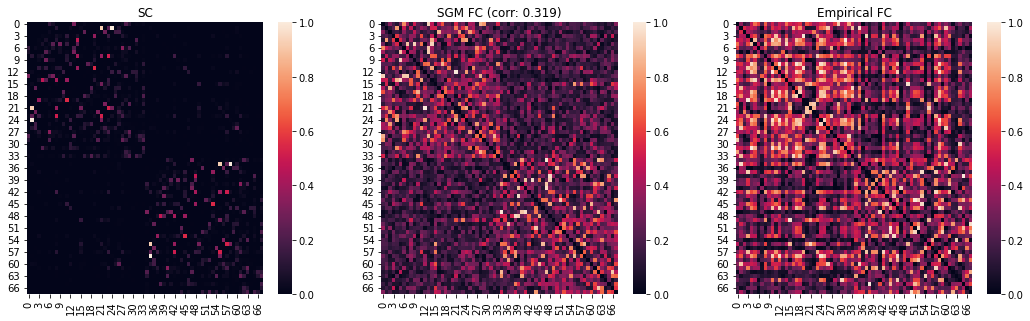

In [36]:
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

### Full Bayesian

In [37]:
cur_idx = 4
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

_simulate_data_sp = partial(_simulate_data, 
                            brain=brain, 
                            prior_bds=paras.prior_bds, 
                            freqrange=paras.freqrange, 
                            diag_ws=paras.diag_ws)
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3))
_simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)

In [38]:
cur_posterior = load_pkl(sorted_fils[cur_idx])

_, cur_post_psds = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                    num_simulations=100, 
                                    num_workers=20)
cur_post_psds = cur_post_psds.reshape(-1, 68, 68);

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2ann_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd40_addv1/ind4.pkl


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
cur_obs_FC = np.abs(fcs[cur_idx])
cur_est_FC = np.abs(cur_post_psds.mean(axis=0).numpy().T)
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]
cal_metrics(cur_obs_FC, cur_est_FC)

{'geo_dist': 0.6268539467525284,
 'reg_r': 0.31767594875600025,
 'lin_r': 0.2749468087443275,
 'tau_r': 0.18147617334547136,
 'sp_r': 0.26855491191780495,
 'mse': 0.07104266304124571,
 'reg_r_block': 0.2518219960553199,
 'lin_r_block': 0.22300747875674973}

<AxesSubplot:title={'center':'SC'}>

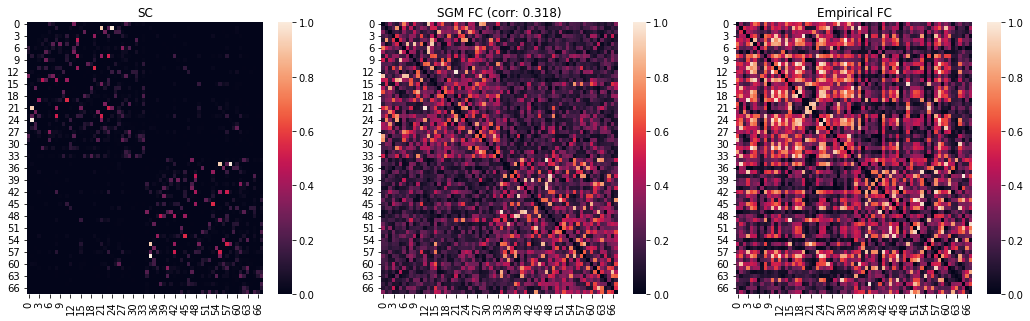

In [40]:
# no diag ws, only three sgm parameters
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

## All data analysis

In [50]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [51]:
inf_res = edict()
inf_res.est_FCs = []

metrics = []
for sub_idx in range(36):
    print(sub_idx)
    cur_posterior = load_pkl(sorted_fils[sub_idx], False)
    post_sps = cur_posterior.sample((1000, ))
    print(post_sps.shape)
    cur_est_paras = torch.median(post_sps, axis=0)[0]
        
    # get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
        
    cur_obs_FC = np.abs(fcs[sub_idx])
    cur_est_FC = np.abs(_simulate_data(cur_est_paras, 
                                   brain=brain, 
                                   prior_bds=paras.prior_bds, 
                                   freqrange=paras.freqrange, 
                                   diag_ws=paras.diag_ws
                                  ))
    est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
    obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
    metrics.append(cal_metrics(cur_obs_FC, cur_est_FC))
    inf_res.est_FCs.append(cur_est_FC)
inf_res.metrics = metrics
save_pkl(sorted_fils[0].parent/"inf_res.pkl", inf_res, False)

0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
1


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
2


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
3


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
4


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
5


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
6


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
7


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
8


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
9


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
10


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
11


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
12


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
13


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
14


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
15


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
16


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
17


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
18


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
19


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
20


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
21


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
22


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
23


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
24


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
25


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
26


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
27


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
28


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
29


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
31


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
32


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
33


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
34


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
35


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2annep100_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd160_addv1/inf_res.pkl


In [52]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638735,0.428335,0.337231,0.201594,0.297179,0.054018,0.381822,0.318677
std,0.020422,0.065390,0.058991,0.044728,0.063802,0.009359,0.064245,0.053633
min,0.603385,0.276068,0.230410,0.117031,0.175103,0.041811,0.241926,0.224890
25%,0.627618,0.390788,0.297769,0.175682,0.260519,0.047078,0.329574,0.270391
50%,0.635038,0.442599,0.336827,0.192343,0.284266,0.051676,0.400180,0.333672
75%,0.650465,0.466206,0.379609,0.235460,0.346938,0.058700,0.425127,0.362524
max,0.681387,0.561835,0.440388,0.307609,0.443982,0.077155,0.512446,0.420017


In [41]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638225,0.422297,0.334474,0.198573,0.292795,0.053809,0.374407,0.314599
std,0.019530,0.071917,0.061650,0.047054,0.067310,0.009018,0.070461,0.057841
min,0.603233,0.236025,0.228476,0.103366,0.154710,0.041707,0.197659,0.192932
25%,0.627183,0.387758,0.297087,0.174415,0.258769,0.047183,0.317640,0.263139
50%,0.635859,0.440704,0.337415,0.191850,0.283477,0.051509,0.397525,0.331536
75%,0.650072,0.466348,0.379410,0.232250,0.341728,0.059618,0.422471,0.362089
max,0.678327,0.560700,0.440691,0.307403,0.443798,0.073992,0.510843,0.419852


In [21]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638238,0.407344,0.326732,0.189963,0.280445,0.053189,0.356155,0.302878
std,0.019191,0.075885,0.064885,0.047683,0.068559,0.008747,0.075095,0.063727
min,0.603083,0.247399,0.208223,0.083750,0.125741,0.041351,0.218104,0.179628
25%,0.625527,0.372837,0.278448,0.162169,0.239476,0.046471,0.293571,0.238590
50%,0.640937,0.416614,0.324295,0.183707,0.271563,0.050878,0.381988,0.319551
75%,0.648467,0.461512,0.379526,0.212989,0.313787,0.059098,0.404733,0.352853
max,0.675797,0.558944,0.439814,0.303147,0.438596,0.072009,0.508427,0.418732


In [20]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.647076,0.367870,0.303632,0.169004,0.250180,0.052843,0.312165,0.271480
std,0.020243,0.083373,0.070652,0.047453,0.068761,0.008607,0.077790,0.068451
min,0.605601,0.201140,0.173329,0.081160,0.121868,0.041212,0.165345,0.139523
25%,0.636266,0.309632,0.252991,0.136146,0.202684,0.046373,0.245602,0.221010
50%,0.648060,0.363823,0.296147,0.164441,0.244024,0.050299,0.327236,0.274382
75%,0.665359,0.436283,0.363714,0.190010,0.282966,0.058414,0.368424,0.317537
max,0.680735,0.540590,0.423064,0.269294,0.394350,0.071946,0.485102,0.401633


In [21]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638220,0.405606,0.326151,0.189193,0.279372,0.053170,0.354067,0.301891
std,0.019257,0.076334,0.064828,0.048403,0.069621,0.008715,0.074489,0.063271
min,0.602759,0.242760,0.205651,0.081998,0.123158,0.041360,0.223201,0.175328
25%,0.628828,0.348585,0.278215,0.157029,0.233368,0.046464,0.285459,0.242729
50%,0.641117,0.422031,0.328882,0.181428,0.268754,0.050280,0.384527,0.319402
75%,0.648414,0.454403,0.373481,0.220958,0.327864,0.058566,0.409784,0.349378
max,0.677122,0.555496,0.436350,0.300678,0.435466,0.071959,0.503827,0.415704


In [20]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.643468,0.379214,0.310447,0.174556,0.258285,0.052827,0.323461,0.279533
std,0.019009,0.076103,0.065052,0.044965,0.065106,0.008662,0.071116,0.062288
min,0.609754,0.230240,0.193279,0.082645,0.124082,0.041209,0.186205,0.148094
25%,0.630223,0.334619,0.266154,0.142757,0.211939,0.046338,0.257778,0.225841
50%,0.645276,0.377902,0.298017,0.173610,0.257451,0.050195,0.346486,0.289812
75%,0.653516,0.443455,0.361697,0.194269,0.289186,0.059096,0.374324,0.320145
max,0.679830,0.528627,0.418106,0.269636,0.394831,0.071975,0.470943,0.390412


In [45]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.673234,0.280132,0.224623,0.128395,0.190835,0.057691,0.225461,0.186728
std,0.029197,0.087506,0.066345,0.038488,0.056633,0.008161,0.087126,0.068306
min,0.623502,0.065645,0.062117,0.019120,0.028950,0.044554,0.026561,0.023938
25%,0.656180,0.230501,0.189046,0.106002,0.158192,0.051216,0.182001,0.154654
50%,0.670617,0.286476,0.230793,0.131964,0.196081,0.057479,0.229981,0.190228
75%,0.681553,0.331113,0.275145,0.152837,0.227588,0.062696,0.281527,0.228085
max,0.781974,0.434684,0.352480,0.192797,0.285480,0.077729,0.398713,0.322785


In [23]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.662562,0.273267,0.243775,0.133097,0.198102,0.055565,0.218019,0.196300
std,0.019081,0.055996,0.048914,0.028782,0.042361,0.007392,0.055654,0.048228
min,0.617322,0.132777,0.110380,0.058295,0.086882,0.044860,0.117989,0.100616
25%,0.650207,0.237380,0.215005,0.115846,0.171909,0.050207,0.182674,0.166197
50%,0.661226,0.277591,0.247200,0.132796,0.197597,0.053446,0.210029,0.194258
75%,0.673963,0.309287,0.272117,0.150207,0.223748,0.060757,0.264324,0.230027
max,0.699880,0.390543,0.346376,0.183496,0.272866,0.074375,0.332252,0.307250


### Full Bayesian

In [53]:
inf_res_fb = edict()
inf_res_fb.est_FCs = []
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3))

metrics = []
for sub_idx in range(36):
    print(sub_idx)
# get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    
    _simulate_data_sp = partial(_simulate_data, 
                                brain=brain, 
                                prior_bds=paras.prior_bds, 
                                freqrange=paras.freqrange,
                                diag_ws=paras.diag_ws)
    _simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)
    
    cur_posterior = load_pkl(sorted_fils[sub_idx], False)
    tmp_sps, cur_post_fcs = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                        num_simulations=1000, 
                                        num_workers=50)
    print(cur_post_fcs.shape)
    cur_post_fcs = cur_post_fcs.reshape(-1, 68, 68)
    
    cur_obs_FC = np.abs(fcs[sub_idx])
    cur_est_FC = np.abs(cur_post_fcs.mean(axis=0).numpy())
    inf_res_fb.est_FCs.append(cur_est_FC)
    metrics.append(cal_metrics(cur_obs_FC, cur_est_FC))
    
inf_res_fb.metrics = metrics
save_pkl(sorted_fils[0].parent/"inf_res_fb.pkl", inf_res_fb)

0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
1


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
2


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
3


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
4


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
5


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
6


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
7


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
8


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
9


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
10


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
11


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
12


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
13


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
14


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
15


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
16


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
17


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
18


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
19


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
20


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
21


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
22


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
23


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
24


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
25


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
26


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
27


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
28


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
29


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
31


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
32


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
33


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
34


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
35


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2annep100_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd160_addv1/inf_res_fb.pkl


In [54]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638897,0.424521,0.327709,0.196489,0.289884,0.055056,0.376312,0.309243
std,0.020436,0.062037,0.056413,0.042125,0.060279,0.009508,0.060941,0.051223
min,0.606439,0.280471,0.226146,0.111868,0.167235,0.041900,0.247256,0.232391
25%,0.622341,0.389127,0.289523,0.170391,0.253074,0.048173,0.330294,0.262294
50%,0.635367,0.435712,0.318322,0.189183,0.279450,0.053058,0.388203,0.321494
75%,0.651083,0.462459,0.366708,0.227239,0.335087,0.060213,0.417916,0.351799
max,0.681418,0.556705,0.429865,0.299011,0.432254,0.079528,0.506484,0.409766


In [43]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.638012,0.420372,0.326813,0.194613,0.287162,0.054597,0.371008,0.307361
std,0.020013,0.064443,0.056966,0.043153,0.061809,0.009098,0.062656,0.052177
min,0.605244,0.276553,0.225446,0.104156,0.155946,0.041977,0.242703,0.227018
25%,0.621475,0.387805,0.288288,0.169489,0.251850,0.048007,0.317348,0.256486
50%,0.635208,0.434656,0.318127,0.188430,0.277609,0.052833,0.387282,0.321850
75%,0.650645,0.459753,0.367100,0.225446,0.331873,0.059329,0.415412,0.349967
max,0.680499,0.553257,0.427549,0.298811,0.432007,0.076488,0.501914,0.407297


In [33]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.637895,0.399512,0.318952,0.183916,0.271845,0.053338,0.345731,0.293287
std,0.018868,0.070348,0.060996,0.043722,0.063120,0.008463,0.067587,0.058693
min,0.606026,0.255712,0.212581,0.087259,0.130987,0.041533,0.238468,0.178536
25%,0.624361,0.347441,0.279445,0.156305,0.231532,0.046630,0.275936,0.238690
50%,0.637758,0.404207,0.314326,0.181732,0.268701,0.050688,0.369436,0.308329
75%,0.648631,0.449356,0.362236,0.207407,0.305353,0.057726,0.397386,0.333158
max,0.676705,0.546576,0.424074,0.277793,0.404771,0.072340,0.493141,0.403510


In [33]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.637895,0.399512,0.318952,0.183916,0.271845,0.053338,0.345731,0.293287
std,0.018868,0.070348,0.060996,0.043722,0.063120,0.008463,0.067587,0.058693
min,0.606026,0.255712,0.212581,0.087259,0.130987,0.041533,0.238468,0.178536
25%,0.624361,0.347441,0.279445,0.156305,0.231532,0.046630,0.275936,0.238690
50%,0.637758,0.404207,0.314326,0.181732,0.268701,0.050688,0.369436,0.308329
75%,0.648631,0.449356,0.362236,0.207407,0.305353,0.057726,0.397386,0.333158
max,0.676705,0.546576,0.424074,0.277793,0.404771,0.072340,0.493141,0.403510


In [23]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.637749,0.407780,0.323047,0.188527,0.278434,0.053692,0.356020,0.299700
std,0.019542,0.071680,0.060433,0.045062,0.064860,0.008502,0.070043,0.058475
min,0.605808,0.250506,0.210241,0.085285,0.127993,0.041758,0.235135,0.191752
25%,0.623827,0.373063,0.283591,0.159935,0.238418,0.047142,0.289960,0.238904
50%,0.635391,0.413047,0.318855,0.185277,0.274316,0.052034,0.377961,0.319914
75%,0.647213,0.457739,0.367866,0.213537,0.315914,0.058283,0.408315,0.345614
max,0.678403,0.552831,0.427915,0.295255,0.427925,0.072140,0.501253,0.407485


In [22]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.645210,0.371754,0.304315,0.170639,0.252577,0.052898,0.315873,0.273137
std,0.020672,0.080323,0.068272,0.046459,0.067327,0.008542,0.075005,0.066179
min,0.606529,0.228382,0.175492,0.080945,0.121588,0.041216,0.176969,0.139532
25%,0.630297,0.310020,0.254458,0.138188,0.205905,0.046441,0.245709,0.221301
50%,0.647217,0.368263,0.297031,0.168387,0.250855,0.050567,0.333420,0.276792
75%,0.664505,0.433243,0.362252,0.191269,0.283302,0.057558,0.366400,0.317300
max,0.680215,0.537878,0.420318,0.268887,0.393779,0.072044,0.481909,0.398836


In [23]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.637527,0.406567,0.322374,0.187870,0.277505,0.053654,0.354479,0.298847
std,0.019258,0.070886,0.059972,0.045074,0.064924,0.008535,0.068784,0.058024
min,0.605397,0.249073,0.209408,0.084710,0.127156,0.041753,0.233746,0.183353
25%,0.623577,0.354975,0.280678,0.158285,0.234450,0.047140,0.290960,0.244276
50%,0.636426,0.415243,0.322765,0.182987,0.270459,0.051078,0.378315,0.317603
75%,0.646914,0.449879,0.363803,0.217935,0.323541,0.058112,0.408122,0.343823
max,0.676326,0.547647,0.424710,0.290940,0.422287,0.072148,0.494504,0.404192


In [23]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.641730,0.382487,0.311320,0.175732,0.260011,0.052859,0.326731,0.281205
std,0.019450,0.072626,0.062908,0.043580,0.063137,0.008540,0.067958,0.060054
min,0.609004,0.245862,0.197318,0.083213,0.124959,0.041328,0.191061,0.150805
25%,0.626700,0.338900,0.268093,0.149786,0.222350,0.046334,0.257603,0.228634
50%,0.644374,0.383894,0.300295,0.173816,0.257471,0.050263,0.349371,0.291479
75%,0.653945,0.444692,0.359149,0.195131,0.290501,0.057671,0.374846,0.318940
max,0.678258,0.527164,0.415523,0.267042,0.391283,0.072034,0.469373,0.388675


In [28]:
metrics_df = pd.DataFrame(metrics);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.652021,0.284117,0.253625,0.137561,0.204592,0.054775,0.227642,0.205158
std,0.018120,0.048941,0.044800,0.027826,0.040962,0.007163,0.049963,0.045129
min,0.608112,0.150778,0.127167,0.061387,0.091515,0.044724,0.129083,0.108635
25%,0.642117,0.252145,0.226888,0.122006,0.182129,0.049582,0.200718,0.177613
50%,0.650636,0.286202,0.261466,0.137520,0.205477,0.053468,0.223706,0.207253
75%,0.661636,0.313969,0.284504,0.156865,0.233528,0.059297,0.272886,0.230896
max,0.683904,0.389925,0.344303,0.188260,0.279623,0.073492,0.331047,0.305865


### Compare

In [24]:
import pandas as pd

In [35]:
dir0 =  f"rawfc2_posteriorMRmul_alpha_" + \
        f"num1000_" + \
        f"densitynsf_" + \
        f"MR3_" + \
        f"noise_sd20_" +\
        f"addv1"
dir1 =  f"rawfc2ep20_posteriorMRmul_alpha_" + \
        f"num1000_" + \
        f"densitynsf_" + \
        f"MR3_" + \
        f"noise_sd20_" +\
        f"addv1"
dir2 =  f"rawfc2ep100_posteriorMRmul_alpha_" + \
        f"num1000_" + \
        f"densitynsf_" + \
        f"MR3_" + \
        f"noise_sd20_" +\
        f"addv1"
res0 = load_pkl(RES_ROOT/dir0/"inf_res_fb.pkl");
res1 = load_pkl(RES_ROOT/dir1/"inf_res_fb.pkl");
res2 = load_pkl(RES_ROOT/dir2/"inf_res_fb.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2ep20_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc2ep100_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl


In [38]:
out_df = {
    "Epoch 1": pd.DataFrame(res0.metrics).mean(),
    "Epoch 20": pd.DataFrame(res1.metrics).mean(),
    "Epoch 100": pd.DataFrame(res2.metrics).mean()}
pd.DataFrame(out_df).iloc[[1, 2, 4, 5], :]

,Epoch 1,Epoch 20,Epoch 100
reg_r,0.041080,0.213930,0.292925
lin_r,0.015040,0.175168,0.246922
sp_r,0.039902,0.158989,0.209433
mse,0.222770,0.070833,0.054957
